<a href="https://colab.research.google.com/github/qingant/.emacs.d/blob/master/Retention_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Retention Forcast

1. calculate `MonthlyRetention` by #PoliciesAtLestRemainXMonth/(#PoliciesAtLestRemainXMonth + #ChurnInXthMonth)
2. calculate `CumulativeRetention` for Xth month by Y = MonthlyRetention(0)*MonthlyRetention(1)...MonthlyRetention(X)
3. fit `CumulativeRetention` with the form `a*log(b*(x+1)) + c`
4. calculate `discounted expected lifetime` by `y = retention(0) * discount^0 + retention(1)*discount^1 + retention*discount^2  ...`

So if you need LTV and assume we have fixed premium every month, the LTV simply equals `(discounted expected lifetime)*premium`


## Expected Lifetime
I think  the discounted expected lifetime may make more sense than non-discounted expected lifetime.


Discounted Expected Lifetime(years) with no time limit: 4.8


Not Discounted Expected Lifetime(years) in 240 months: 7

if we did not do discount on expected lifetime, the expected lifetime will be meaningless high because the retention function decrease slower and slower over time.



## Fitted Retention in 240 months
... too much data points， formula:

CulmulativeRetention(x) =  -0.23*log(0.393*(x+1.162)) + 6.423

in which x represent the Xth month


## Qustions
1. is the data correct ? why we did not have big drop around 6th month and 12th month which is usually when the policies terminated
2. we assume the retention function is basically some form about log which is reasonable but may not be accurate after maybe 10 years.



# Implementation


In [ ]:
#@title
import pandas as pd
df = pd.read_csv('https://owl.paoying.net/data.csv')
df['month'] = df['Months on Book']
df['Policies'] = df.Policies.map(lambda x: x if type(x) is int else int(x.replace(',', '')))

# retention IN THIS MONTH
df['MonthlyRetention'] = df['Policies']/(df['Policies'] + df['Churn'])

In [ ]:
#@title
df

,Months on Book,Policies,Churn,Churn %,Cumulative Churn,Cumulative Retention,month,MonthlyRetention
0,1,18140,385,2.12%,2.12%,97.88%,1,0.979217
1,2,14400,995,6.91%,9.03%,90.97%,2,0.935369
2,3,11492,552,4.80%,13.84%,86.16%,3,0.954168
3,4,8994,341,3.79%,17.63%,82.37%,4,0.963471
4,5,6908,208,3.01%,20.64%,79.36%,5,0.970770
5,6,4912,109,2.22%,22.86%,77.14%,6,0.978291
6,7,3515,57,1.62%,24.48%,75.52%,7,0.984043
7,8,2514,45,1.79%,26.27%,73.73%,8,0.982415
8,9,1811,19,1.05%,27.32%,72.68%,9,0.989617
9,10,1374,16,1.16%,28.48%,71.52%,10,0.988489


In [ ]:
#@title
from functools import reduce
df['CumulativeRetention'] = df['MonthlyRetention'].index.map(lambda i: reduce(lambda x, y: x*y, df[df.index <= i]['MonthlyRetention']))
df['CumulativeChurch'] = 1 - df['CumulativeRetention']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
#@title
# df

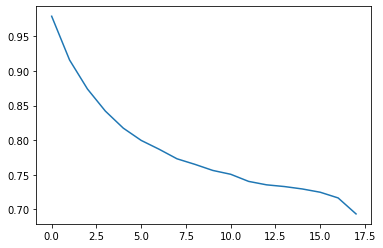

In [ ]:
#@title
import matplotlib.pyplot as plt
df = df[df.index < 18]
plt.plot(df['CumulativeRetention'])
#plt.plot(df['CumulativeChurch'])
plt.show()

In [ ]:
#@title
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

key = 'CumulativeRetention'
# key = 'MonthlyRetention'
x = df[key].index
y = df[key].values




discount = 0.995735 # for every month
# discount = 1
def get_lf(func, popt, discount, limit=240):
  px = range(limit)
  py = [func(x, *popt) for x in px]
  expected_lifetime = 0
  for i, v in enumerate(py):
    expected_lifetime += v *(discount ** i)
    if v < 0.01: break
  return expected_lifetime

def get_lfv(func, popt, discount, limit=240):
  px = range(limit)
  py = [func(x, *popt) for x in px]
  expected_lifetime = 0
  for i, v in enumerate(py):
    expected_lifetime += v *(discount ** i) * 154.17 * (0.125 if i < 12 else 0.11)
    if v < 0.01:
      break
  return expected_lifetime

def show_option(func, factor=None, formula=None):
    popt, pcov = curve_fit(func, x, y)
    a, b, c, d = popt
    a = factor or a
    # print(round(a, 4))
    if formula is not None:
        print('Formula: ', formula.format(a=round(a, 4), b=round(b, 4), c=round(c, 4), d=round(d, 4)))
    else:
        print('Formula: ', f'Y = {round(a, 4)}*log({round(b, 4)}*(x+{round(d, 4)})) + {round(c, 4)}')
    # print('Formula: ', f'Y = {round(a, 4)}*log({round(b, 4)}*(x+{round(d, 4)})) + {round(c, 4)}')
    print('Retention of 240th month: ', round(func(240, *popt), 4))
    print('Expected Lifetime(years) in 240 months:', round(get_lf(func, popt, 1)/12))
    print('Non-restricted Expected Lifetime:', round(get_lf(func, popt, 1, 10000)/12))

    print('NonRestricted Discounted LTV:', round(get_lfv(func, popt, discount, limit=10000)))
    print('Discounted LTV in 240 months:', round(get_lfv(func, popt, discount, limit=240)))
    # perr = np.sqrt(np.diag(pcov))
    plt.figure()
    plt.plot(x, y, 'ko', label="Original Data")
    x1 = x
    plt.plot(x1, func(x1, *popt), 'r-', label="Fitted Curve")
    plt.legend()
    plt.show()

    x1 = np.array(range(240))
    y1 = func(x1, *popt)
    plt.figure()
    plt.plot(x, y, 'ko', label="Original Data")

    plt.plot(x1, y1, 'r-', label="Fitted Curve")
    plt.legend()
    plt.show()

# Options

Formula:  Y = -0.0938*log(4.1088*(x+1.0)) + 1.1074
Retention of 240th month:  0.4603
Expected Lifetime(years) in 240 months: 11.0
Non-restricted Expected Lifetime: 170.0
NonRestricted Discounted LTV: 2074.0
Discounted LTV in 240 months: 1495.0


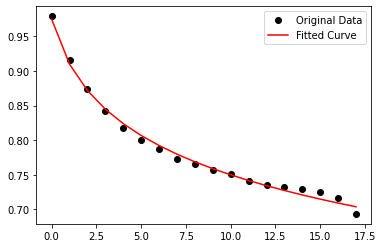

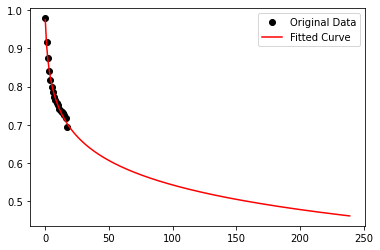

In [ ]:
# original fit without any magic
def func(x, a, b, c, d):
    # return a*np.log(b*(x+1)) + c
    return a*np.log(b*(x+1)) + c
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    show_option(func)

Formula:  Y = -0.26*log(0.7189*(x+11.2216)) + 1.4702
Retention of 240th month:  0.1088
Expected Lifetime(years) in 240 months: 7.0
Non-restricted Expected Lifetime: 7.0
NonRestricted Discounted LTV: 1049.0
Discounted LTV in 240 months: 1015.0


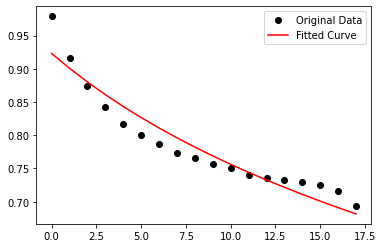

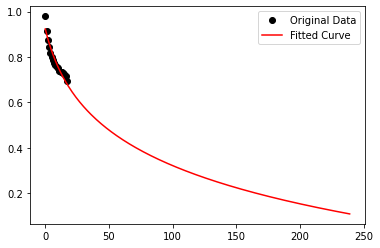

In [ ]:
# drop to 0.1 at 240th month
def func(x, a, b, c, d):
    # return a*np.log(b*(x+1)) + c
    return -0.262*np.log(b*(x+d)) + c
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    show_option(func, -0.26)

Formula:  Y = -0.21*log(0.4882*(x+7.5502)) + 1.2053
Retention of 240th month:  0.1984
Expected Lifetime(years) in 240 months: 8.0
Non-restricted Expected Lifetime: 10.0
NonRestricted Discounted LTV: 1256.0
Discounted LTV in 240 months: 1129.0


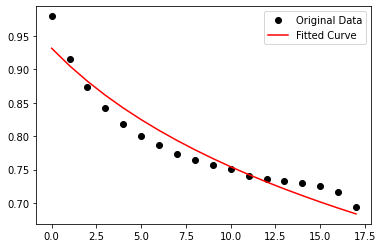

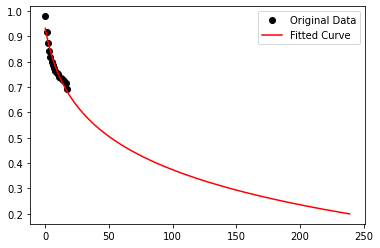

In [ ]:
# drop to 0.2 at 240th month
factor = -0.21
def func(x, a, b, c, d):
    # return a*np.log(b*(x+1)) + c
    return factor*np.log(b*(x+d)) + c
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    show_option(func, factor)

Formula:  Y = -0.237*log(1.3143*(x+9.4355)) + 1.5233
Retention of 240th month:  0.1505
Expected Lifetime(years) in 240 months: 7.0
Non-restricted Expected Lifetime: 8.0
NonRestricted Discounted LTV: 1136.0
Discounted LTV in 240 months: 1067.0


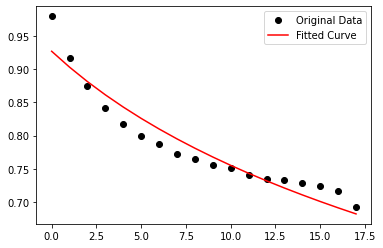

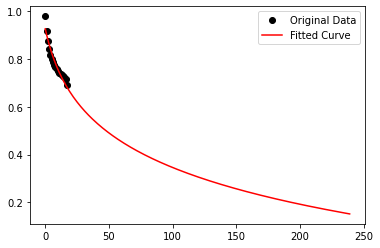

In [ ]:
# drop to 0.15 at 240th month
factor = -0.237
def func(x, a, b, c, d):
    # return a*np.log(b*(x+1)) + c
    return factor*np.log(b*(x+d)) + c
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    show_option(func, factor)

Formula:  0.1526*(x + 1)^(-0.7) + 0.8359 + -0.0288*(x)^0.59
Retention of 240th month:  0.1085
Expected Lifetime(years) in 240 months: 8.0
Non-restricted Expected Lifetime: 8.0
NonRestricted Discounted LTV: 1172.0
Discounted LTV in 240 months: 1153.0


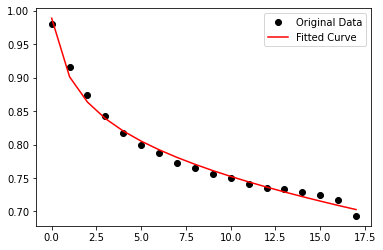

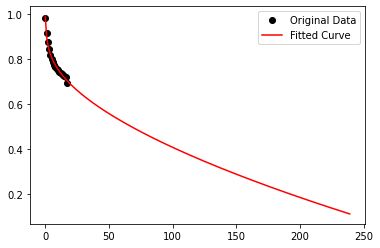

In [ ]:
# NEW FIT: drop to 0.1 at 240th month
# Changed the form a little bit to make it more interpretable

def func(x, a, b, c, d):
    # return a*np.log(b*(x+1)) + c
    return a*(x + 1)**(-0.7) + b + c*(x)**0.59
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    show_option(func, formula='{a}*(x + 1)^(-0.7) + {b} + {c}*(x)^0.59')